In [26]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
a = np.array([49, 58, 75, 110, 112, 132, 151, 276, 281, 362])
print("M: %d, p-value: %f" % sign_test([], 100))

M: 0, p-value: 1.000000


### 4

In [6]:
m0 = 200
stats.wilcoxon(a - m0)

WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)

### 5

In [7]:
a = [22,22,15,13,19,19,18,20,21,13,13,15]
b = [17,18,18,15,12,4,14,15,10]

In [9]:
stats.mannwhitneyu(b, a, alternative='less')

MannwhitneyuResult(statistic=27.0, pvalue=0.02900499272087373)

### 6

In [14]:
df = pd.read_table('Data/challenger.txt', index_col=0)

In [38]:
df.head()

,Temperature,Incident
Apr12.81,18.9,0
Nov12.81,21.1,1
Mar22.82,20.6,0
Nov11.82,20.0,0
Apr04.83,19.4,0


In [64]:
damaged = df[df['Incident'] == 1]['Temperature'].values
normal = df[df['Incident'] == 0]['Temperature'].values

In [35]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [42]:
def get_random_combinations(n1, n2, max_combinations):
    index = [i for i in range(n1 + n2)]
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [30]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

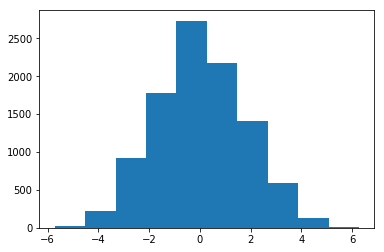

In [32]:
plt.hist(permutation_zero_dist_ind(normal, damaged, max_combinations = 10000));

In [33]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [46]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [50]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [65]:
np.random.seed(0)

ilec_mean_scores = list(map(np.mean, get_bootstrap_samples(normal, 10000)))
clec_mean_scores = list(map(np.mean, get_bootstrap_samples(damaged, 10000)))

print("95% confidence interval for the ILEC median repair time:",  stat_intervals(ilec_mean_scores, 0.05))
print("95% confidence interval for the CLEC median repair time:",  stat_intervals(clec_mean_scores, 0.05))

95% confidence interval for the ILEC median repair time: [21.03125 23.56875]
95% confidence interval for the CLEC median repair time: [14.58571429 20.78571429]


In [66]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(ilec_mean_scores, clec_mean_scores)))

In [67]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians [-8.04379464 -1.29272321]


### 7

In [68]:
np.random.seed(0)
permutation_test(normal, damaged, max_permutations=10000)

0.007

Apr12.81    18.9
Mar22.82    20.6
Nov11.82    20.0
Apr04.83    19.4
Jun18.83    22.2
Aug30.83    22.8
Nov28.83    21.1
Oct05.84    25.6
Nov08.84    19.4
Apr12.85    19.4
Apr29.85    23.9
Jun17.85    21.1
Jul29.85    27.2
Aug27.85    24.4
Oct03.85    26.1
Nov26.85    24.4
Name: Temperature, dtype: float64